In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
datasetname='2nd-CuSn-MFF-FE-HCOOHCO.csv'
strlist = datasetname.split('.') 
savename=strlist[0]
dataset = pd.read_csv(datasetname)
print(dataset.head())
col = dataset.columns.values.tolist()
headers =col[0:-1]
features = np.array(dataset[headers])
labels = dataset['FEHCOOH/CO']

   CCN  C=O  CCC  CCC[C@@H](C)N  CO  C[C@H](N)C(=O)O  CN  CCCCN  CC(=O)O  \
0    3    1    4              1   1                1   2      2        1   
1    2    2    3              1   2                1   1      1        2   
2    0    0    0              0   0                0   0      0        0   
3    3    1    3              1   1                1   4      2        1   
4    0    2    0              0   2                0   0      0        0   

   CC[C@H](N)C(=O)O  ...  cc(C)nc(c)C  cc(C)n  ccc(nc)-c(c)n  cc(c)OC  \
0                 1  ...            0       0              0        0   
1                 1  ...            0       0              0        0   
2                 0  ...            0       0              0        0   
3                 1  ...            0       0              0        0   
4                 0  ...            0       0              0        0   

   ccc(cc)OC  COc  cc(O)ccn  Cc  cnc[nH]c  FEHCOOH/CO  
0          0    0         0   0         0       

In [2]:
plot_gbct_name_1= 'Feature importance of GBCT model in '+str(savename)+'.png'
plot_gbct_name_2= 'Confusion Matrix of GBCT model in '+str(savename)+'.png'
plot_gbct_name_3= 'ROC curve of GBCT model in '+str(savename)+'.png'
plot_gbct_name_4= 'Feature importance2 of GBCT model in '+str(savename)+'.png'

from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit
X=features
y=labels

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.15, random_state=19)

# TRAIN_TEST_SPLIT=0.85
# point = round(X.shape[0]*TRAIN_TEST_SPLIT)
# permutation = np.random.permutation(y.shape[0])
# X_train = X[permutation[:point], :]
# y_train = y[permutation[:point]]
# X_test = X[permutation[point:], :]
# y_test = y[permutation[point:]]
cv = StratifiedShuffleSplit(n_splits=50, test_size=0.15, random_state=4)

In [4]:
#GBCT model
from sklearn.ensemble import GradientBoostingClassifier
tuned_parameters = [{'learning_rate': [0.0025,0.01,0.05], 'subsample': [0.5], 'min_impurity_decrease': [0.3,0.5],
                     'max_depth': [4, 6], 'warm_start': [False], 'max_features': ['sqrt'], 'max_leaf_nodes': [4,6],'n_estimators':[500,1000,5000]}]
gbct= GradientBoostingClassifier(verbose=0, validation_fraction=0.15, n_iter_no_change=50, tol=0.0001)

gbct = GridSearchCV(gbct, tuned_parameters, verbose=1, scoring=None, cv=cv, n_jobs=16)
gbct.fit(X_train, y_train)
gbct_new = gbct.best_estimator_
best_p = gbct.best_params_
paras = gbct_new.get_params()
print(best_p)
acc_unique = gbct_new.score(X_test, y_test)
print('Current accuracy:', acc_unique)
gbct=gbct.best_estimator_

Fitting 50 folds for each of 72 candidates, totalling 3600 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    3.7s
[Parallel(n_jobs=16)]: Done 580 tasks      | elapsed:    8.3s
[Parallel(n_jobs=16)]: Done 1280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=16)]: Done 2180 tasks      | elapsed:   22.9s
[Parallel(n_jobs=16)]: Done 3280 tasks      | elapsed:   30.2s
[Parallel(n_jobs=16)]: Done 3569 out of 3600 | elapsed:   32.1s remaining:    0.3s


{'learning_rate': 0.0025, 'max_depth': 6, 'max_features': 'sqrt', 'max_leaf_nodes': 4, 'min_impurity_decrease': 0.5, 'n_estimators': 1000, 'subsample': 0.5, 'warm_start': False}
Current accuracy: 0.2857142857142857


[Parallel(n_jobs=16)]: Done 3600 out of 3600 | elapsed:   32.4s finished


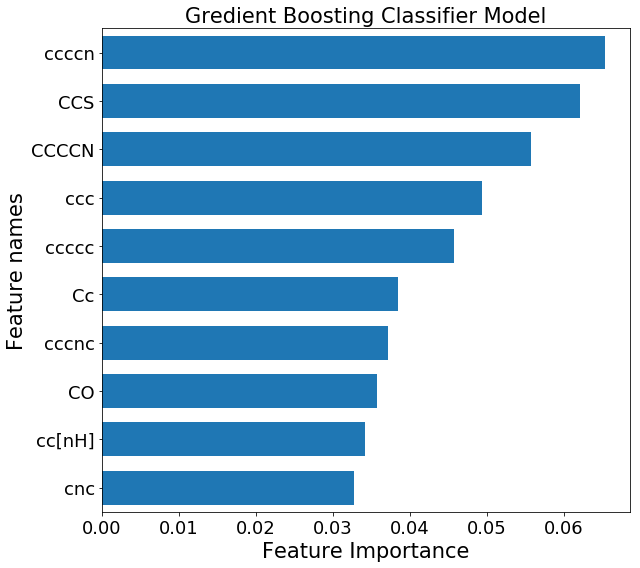

In [5]:
# 将float_list[num]改为np.array(float_list)[num]取消报错
from sklearn.inspection import permutation_importance


tree_importance_sorted_idx = np.argsort(gbct.feature_importances_)
tree_indices = np.arange(0, len(gbct.feature_importances_)) + 0.5

fig, (ax1) = plt.subplots(figsize=(9, 8))
ax1.barh(tree_indices[len(headers)-10:],
         gbct.feature_importances_[tree_importance_sorted_idx[len(headers)-10:]], height=0.7)
ax1.set_yticklabels(np.array(headers)[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((len(headers)-10,len(headers)))
font1 = {'family' : 'Arial',
'weight' : 'normal',
'size'   : 21,}
ax1.set_xlabel('Feature Importance',font1)
ax1.set_ylabel('Feature names',font1)
ax1.set_title("Gredient Boosting Classifier Model",font1)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# # 设置坐标标签字体大小
# ax.set_xlabel(..., fontsize=20)
# ax.set_ylabel(..., fontsize=20)
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
fig.tight_layout()
plt.savefig(plot_gbct_name_1, dpi=600)
plt.show()

In [6]:
feature_numbers=10
idx_third = gbct.feature_importances_.argsort()[-feature_numbers]
threshold = gbct.feature_importances_[idx_third] + 0.01
idx_features = (-gbct.feature_importances_).argsort()[:feature_numbers]
name_features = np.array(headers)[idx_features]
print('Selected features: {}'.format(name_features))
X_transform=dataset[name_features]

Selected features: ['ccccn' 'CCS' 'CCCCN' 'ccc' 'ccccc' 'Cc' 'cccnc' 'CO' 'cc[nH]' 'cnc']


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_transform, labels, test_size=0.15, random_state=19)
# 搭建随机森林模型
#GBCT model
from sklearn.ensemble import GradientBoostingClassifier
tuned_parameters = [{'learning_rate': [0.0025,0.01,0.05], 'subsample': [0.5], 'min_impurity_decrease': [0.3,0.5],
                     'max_depth': [4, 6], 'warm_start': [False], 'max_features': ['sqrt'], 'max_leaf_nodes': [4,6],'n_estimators':[500,1000,5000]}]
gbct= GradientBoostingClassifier(verbose=0, validation_fraction=0.15, n_iter_no_change=50, tol=0.0001)

gbct = GridSearchCV(gbct, tuned_parameters, verbose=1, scoring=None, cv=cv, n_jobs=16)
gbct.fit(X_train, y_train)
gbct_new = gbct.best_estimator_
best_p = gbct.best_params_
paras = gbct_new.get_params()
print(best_p)
acc_unique = gbct_new.score(X_test, y_test)
print('Current accuracy:', acc_unique)
gbct=gbct.best_estimator_

Fitting 50 folds for each of 72 candidates, totalling 3600 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 304 tasks      | elapsed:    4.5s
[Parallel(n_jobs=16)]: Done 804 tasks      | elapsed:   13.2s
[Parallel(n_jobs=16)]: Done 1328 tasks      | elapsed:   22.7s
[Parallel(n_jobs=16)]: Done 1778 tasks      | elapsed:   28.8s
[Parallel(n_jobs=16)]: Done 2328 tasks      | elapsed:   36.6s
[Parallel(n_jobs=16)]: Done 3172 tasks      | elapsed:   44.6s


{'learning_rate': 0.05, 'max_depth': 6, 'max_features': 'sqrt', 'max_leaf_nodes': 4, 'min_impurity_decrease': 0.3, 'n_estimators': 5000, 'subsample': 0.5, 'warm_start': False}
Current accuracy: 0.7142857142857143


[Parallel(n_jobs=16)]: Done 3600 out of 3600 | elapsed:   49.0s finished


feature_name: cnc importance:  0.24383392254091543
feature_name: ccc importance:  0.12428959298632318
feature_name: CO importance:  0.12050261522366691
feature_name: ccccn importance:  0.11356354100521131
feature_name: Cc importance:  0.10062770164834324
feature_name: cccnc importance:  0.0881095393383177
feature_name: ccccc importance:  0.07893266081618239
feature_name: cc[nH] importance:  0.0640375924096392
feature_name: CCCCN importance:  0.054462263478594716
feature_name: CCS importance:  0.011640570552805887


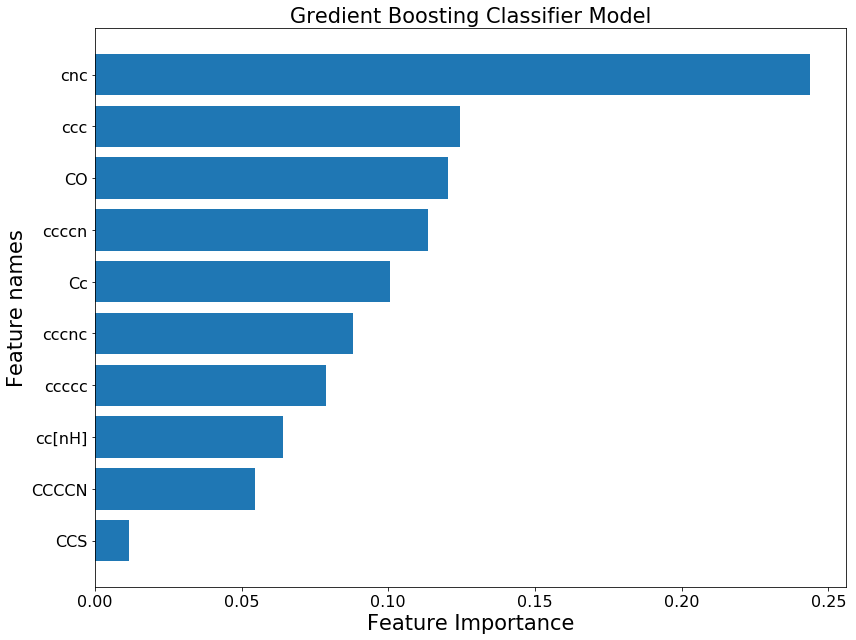

In [8]:
title=name_features
p = np.argsort(-gbct.feature_importances_)
feat=[]
importance=[]
for i in range(len(name_features)):
    print('feature_name:', title[p[i]], 'importance: ',gbct.feature_importances_[p[i]])
    feat.append(title[p[i]])
    importance.append(gbct.feature_importances_[p[i]])
feat=np.array(feat)
importance=np.array(importance)
# Plot the feature importances of the forest
tree_feature_importances = importance
sorted_idx = tree_feature_importances.argsort()
y_ticks = np.arange(0, len(feat))

#设置输出的图片大小
figsize = 12,9
fig, ax = plt.subplots(figsize=figsize)

ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feat[sorted_idx])
ax.set_yticks(y_ticks)
font1 = {'family' : 'Arial',
'weight' : 'normal',
'size'   : 21,}
ax.set_xlabel('Feature Importance',font1)
ax.set_ylabel('Feature names',font1)
ax.set_title("Gredient Boosting Classifier Model",font1)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# # 设置坐标标签字体大小
# ax.set_xlabel(..., fontsize=20)
# ax.set_ylabel(..., fontsize=20)
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=16)
fig.tight_layout()
plt.savefig(plot_gbct_name_4, bbox_inches='tight',dpi=600)
plt.show()

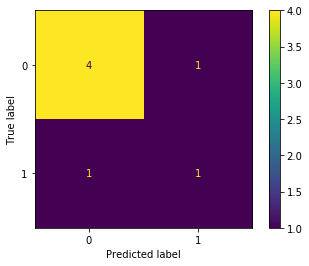

In [9]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(gbct, X_test, y_test)  # doctest: +SKIP
plt.savefig(plot_gbct_name_2, bbox_inches='tight',dpi=600)
plt.show()  # doctest: +SKIP

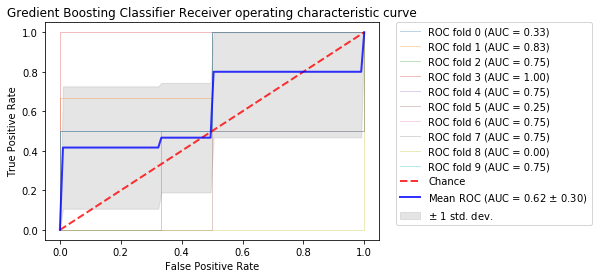

In [10]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

# #############################################################################
# Data IO and generation
n_samples, n_features = X.shape
from sklearn.model_selection import  StratifiedKFold
n_splits=10
cv = StratifiedKFold(n_splits)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    gbct.fit(X[train], y[train])
    viz = plot_roc_curve(gbct, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Gredient Boosting Classifier Receiver operating characteristic curve")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.savefig(plot_gbct_name_3, bbox_inches='tight',dpi=600)
plt.show()
